In [1]:
!git clone https://github.com/TonyYangHan/SemiSeg
import sys
sys.path.append('/content/SemiSeg')
import Semi_supervised_v2
import os, cv2, torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from Semi_supervised_v2 import MultiScaleUNet as MSU

Cloning into 'SemiSeg'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 4), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 2.16 MiB | 17.53 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Opt for the best hardware available
model_path    = "best_student_v2.pth" # The model you want to load
test_img_dir  = "/content/drive/MyDrive/Org Pics for Analysis/D8/Analysis" # The directory to brightfield images you would like to test the model with
test_mask_dir = "test_annotation/" # The directory to masks (black-and-white images) you generated as ground truth for the model to learn

visualize_n = 5 # How many image-truth-prediction pair you would like to visualize
img_size = (512,512) # Resize images to this size
thresh = 0.5 # pixels with probability exceeding this will be predicted as organoid present. Otherwise, not present.

**Please make sure you set the parameters in the cell above correctly before proceeding**

In [ ]:
# Load the model
model = MSU()
model.load_state_dict(torch.load(model_path, map_location=device, weights_only = True))
model.to(device).eval()

MultiScaleUNet(
  (e1): MultiScaleBlock(
    (c1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (c3): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c5): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (c7): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (fuse): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (e2): MultiScaleBlock(
    (c1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (c7): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (fuse): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (e3): MultiScaleBlock(
    (c1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c5): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 

              precision    recall  f1-score   support

  background       0.99      0.98      0.98   3875746
  foreground       0.94      0.97      0.95   1367134

    accuracy                           0.98   5242880
   macro avg       0.96      0.97      0.97   5242880
weighted avg       0.98      0.98      0.98   5242880



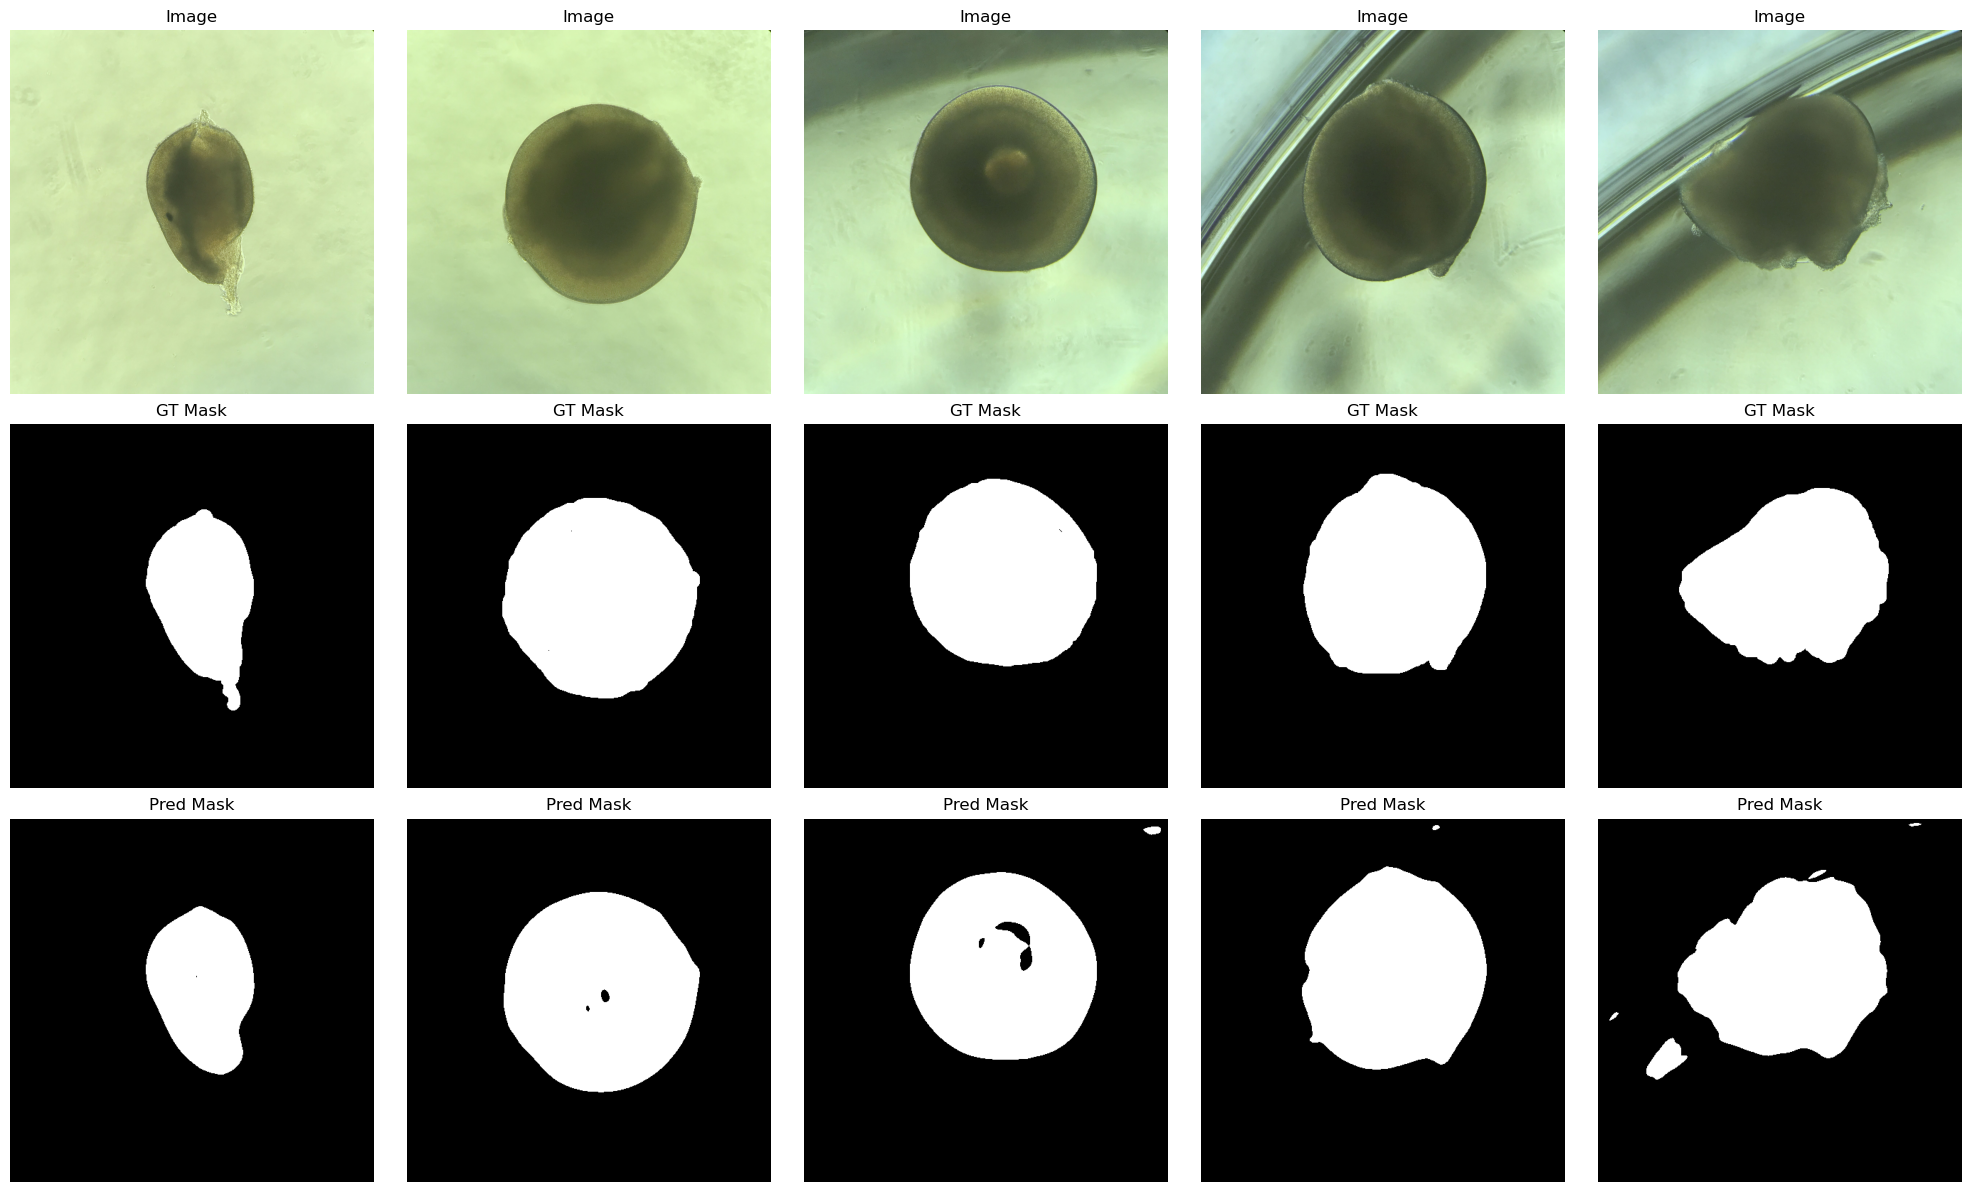

In [ ]:
# 3. Helper to preprocess an image for your model
def preprocess(img_bgr):
    # img_bgr: H×W×3 uint8
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, img_size)
    # normalize to [0,1], then to tensor C×H×W
    tensor = torch.from_numpy(img_rgb.astype(np.float32)/255.0).permute(2,0,1)
    # add batch dim
    return tensor.unsqueeze(0).to(device)

# 4. Loop over your test set
y_true = []
y_pred = []
to_visualize = []

for fname in sorted(os.listdir(test_img_dir)):
    img_path  = os.path.join(test_img_dir,  fname)
    mask_path = os.path.join(test_mask_dir, fname)
    # load
    img  = cv2.imread(img_path)
    m    = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    m = cv2.resize(m, img_size)
    # binarize mask (0 or 1)
    m_bin = (m > 127).astype(np.uint8)

    # inference
    inp = preprocess(img)
    with torch.no_grad():
        logit = model(inp)              # [1,1,H,W]
        prob  = torch.sigmoid(logit)    # [1,1,H,W]
        pred  = (prob > thresh).cpu().numpy()[0,0].astype(np.uint8)

    # flatten for metrics
    y_true.extend(m_bin.flatten().tolist())
    y_pred.extend(pred.flatten().tolist())

    # store for viz
    if len(to_visualize) < visualize_n:
        to_visualize.append((img, m_bin, pred))

# 5. Classification report
print(classification_report(y_true, y_pred,
                            labels=[0,1],
                            target_names=["background","foreground"],
                            zero_division=0))

# 6. Visualization
fig, axes = plt.subplots(3, visualize_n, figsize=(4*visualize_n, 12))
for i, (img, gt, pr) in enumerate(to_visualize):
    # Original
    axes[0,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0,i].set_title("Image")
    axes[0,i].axis("off")
    # Ground truth
    axes[1,i].imshow(gt, cmap="gray")
    axes[1,i].set_title("GT Mask")
    axes[1,i].axis("off")
    # Prediction
    axes[2,i].imshow(pr, cmap="gray")
    axes[2,i].set_title("Pred Mask")
    axes[2,i].axis("off")

plt.tight_layout()
plt.show()

**Note: You will see some prediction is slightly off because this is unprocessed predictions.** <br>
**Raw predictions should be clearned afterwards in the post-processing pipeline (included in Detection.ipynb)**